# REINFORCE in pytorch (5 pts)

Just like we did before for q-learning, this time we'll design a pytorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [37]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

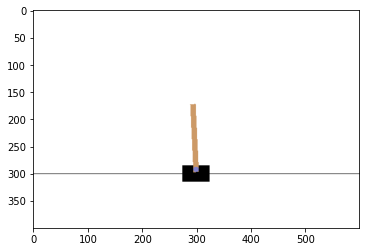

In [38]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [40]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.

state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

model = nn.Sequential(
  nn.Linear(state_dim, 250),
  nn.ReLU(),
  nn.Linear(250, 250),
  nn.ReLU(),
  nn.Linear(250, n_actions)
)

#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [41]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    states = Variable(torch.FloatTensor(states))
    probs = F.softmax(model.forward(states), dim=1)
    return probs.detach().numpy()

In [42]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(
    test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (
    test_states.shape[0], env.action_space.n), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1),
                   1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [43]:
def generate_session(env, t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p = action_probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [44]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

In [45]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    gammas = list()
    gammas.append(rewards[-1])
    
    for reward in rewards[-2::-1]:
        gammas.append(reward + gamma * gammas[-1])
    
    return gammas[::-1]

In [46]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over T } \sum_{i=1}^T  G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over T } \sum_{i=1}^T \log \pi_\theta (a_i \mid s_i) \cdot G(s_i,a_i) $$

Entropy Regularizer
  $$ H = - {1 \over T} \sum_{i=1}^T  \sum_{a \in A} {\pi_\theta(a|s_i) \cdot \log \pi_\theta(a|s_i)}$$

$T$ is session length

So we optimize a linear combination of $- \hat J$, $-H$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.

In [47]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [48]:
# Your code: define optimizers
from torch import optim
optimizer = optim.Adam(model.parameters())


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy = -(probs * log_probs).mean() * entropy_coef
    loss = -torch.mean(log_probs_for_actions * cumulative_returns) - entropy

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [49]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env))
               for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:13.320
mean reward:9.790
mean reward:11.580
mean reward:37.280
mean reward:78.810
mean reward:134.090
mean reward:150.600
mean reward:256.890
mean reward:181.180
mean reward:142.960
mean reward:246.120
mean reward:591.540
You Win!


### Video

In [50]:
# record sessions
import gym.wrappers
monitor_env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(monitor_env) for _ in range(100)]
monitor_env.close()

In [56]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + video_names[0]))  # this may or may not be the _last_ video. Try other indices

В ноутбуке не отобразилось ни одно видео, поэтому добавил всю папку целиком